In [1]:
# Import Statements
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import keras.backend as K
import keras

from tensorflow.keras.utils import plot_model
from tensorflow.keras.activations import *
from keras.models import Model
from keras.layers import *
from keras import optimizers, regularizers
from keras.utils import plot_model
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.losses import*

from numpy import asarray, reshape, array
from sklearn.preprocessing import MinMaxScaler, Normalizer, QuantileTransformer
from matplotlib.gridspec import GridSpec
from pandas import read_csv, to_datetime, DataFrame, concat, merge
import pandas as pd

from plotting import *
from ff_extrapolation import *
from tech_indicator import *      

In [2]:
# Load Data
symbol = 'US30'
timeframe = 'M1'
skip_row, fraction = 10000, 1000000
new_file = 'D:/Data/' + symbol + '_' +  timeframe + '.csv'

if fraction > 0:
        data = read_csv(new_file,
                             header=0,
                             parse_dates=False,
                             skiprows=range(1, skip_row + 1),
                             nrows=fraction)
elif fraction == 0:
        data = read_csv(new_file,
                 header=0,
                 parse_dates=False
                 )

In [3]:
# Time Managment
time = to_datetime(data['Date'],
                   format='%Y%m%d %H:%M:%S',
                   errors='coerce')
df = data.iloc[:, 2:].set_index(time)

In [4]:
# Feature Time
df['Hour'] = df.index.hour
df['Minute'] = df.index.minute

In [5]:
# Indicators
indicators = DataFrame()
window = 20
n_pred = 1
n_fft = 20

df = get_technical_indicators(df)
# df = get_technical_indicators(df)       
# df['FFT'] = fourierExtrapolation(df['Close'],n_fft=n_fft, n_predict=15)[15:]


In [6]:
# Time Shift
delay = 5
df['y'] =  df['Close'].shift(-delay)-df['Close']
# df.head()

In [7]:
# Data Generation
history = 60
chopper = np.max([df.iloc[:, i:i+1].isnull().sum() for i in range(df.shape[1])])
#print(chopper)
chopped_df = df.iloc[chopper:-delay, :]
chopped_df.head()


,Open,High,Low,Close,Volume,Hour,Minute,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,y
Date,,,,,,,,,,,,,,,,,,
2012-02-17 19:48:00,12949.53,12954.15,12949.23,12954.15,25.0,19,48,12949.875714,12950.456667,12950.652202,12950.693031,0.040829,2.371820,12955.200307,12945.713026,12952.550688,12953.15,0.79
2012-02-17 19:49:00,12954.07,12954.22,12952.82,12953.69,24.0,19,49,12949.951429,12950.799048,12950.927944,12951.166093,0.238149,2.376599,12955.552245,12946.045850,12953.310229,12952.69,0.99
2012-02-17 19:50:00,12953.77,12954.41,12953.54,12953.77,19.0,19,50,12950.562857,12951.074762,12951.181682,12951.575473,0.393791,2.401295,12955.877352,12946.272172,12953.616743,12952.77,-0.53
2012-02-17 19:51:00,12953.62,12953.81,12953.05,12953.81,19.0,19,51,12951.622857,12951.312857,12951.412823,12951.925600,0.512777,2.403251,12956.119359,12946.506355,12953.745581,12952.81,-1.02
2012-02-17 19:52:00,12953.88,12955.51,12953.43,12955.17,22.0,19,52,12952.785714,12951.613810,12951.738719,12952.432522,0.693803,2.447923,12956.509656,12946.717963,12954.695194,12954.17,-2.65


In [8]:
# Scaling
scaling = 0
number = 1
X_normalizer = MinMaxScaler()
y_normalizer = MinMaxScaler()
X_normalised = X_normalizer.fit_transform(chopped_df.iloc[:, :-1])
y_normalised = y_normalizer.fit_transform(chopped_df.iloc[:, -1:])

if scaling == 0:
    X_normalised = X_normalizer.inverse_transform(X_normalised)
    y_normalised = y_normalizer.inverse_transform(y_normalised)

In [9]:
# Create X, y
split = np.array([0.6, 0.3])
split = np.cumsum(len(X_normalised) * split)
X = []

X = [np.concatenate((X_normalised[i - history:i, 0:3] - X_normalised[i-1, 3:4], 
                     X_normalised[i - history:i, 4:5],
                     X_normalised[i - history:i, 7:11]- X_normalised[i-1, 3:4],
                     X_normalised[i - history:i, 11:13],
                     X_normalised[i - history:i, 13:]- X_normalised[i-1, 3:4],
                     X_normalised[i - history:i, 5:7]), axis=1)
             for i in range(history + 1, len(chopped_df))]
X = np.flip(X, axis=1)
X_reference = [X_normalised[i-1, 3:4] for i in range(history + 1, len(chopped_df))]
y = [y_normalised[i] for i in range(history, len(chopped_df))]

X_train, X_val, X_test = np.array(X[0:int(split[0])]), np.array(X[int(split[0]):int(split[1])]), np.array(X[int(split[1]):])
X_train_reference, X_val_reference, X_test_reference = np.array(X_reference[0:int(split[0])]), np.array(X_reference[int(split[0]):int(split[1])]), np.array(X_reference[int(split[1]):])
y_train, y_val, y_test = np.array(y[0:int(split[0])]), np.array(y[int(split[0]):int(split[1])]), np.array(y[int(split[1]):])

split = [y_train.shape[0], y_val.shape[0], y_test.shape[0]]

In [10]:
X_train[0][0]

array([ -0.68      ,   1.36      ,  -0.68      ,  29.        ,
        -3.67571429,  -0.63047619,  -1.37287434,  -2.48548529,
        -1.11261095,   5.34928276,  10.06808933, -11.32904171,
        -0.6945893 ,  -1.        ,  20.        ,  48.        ])

In [11]:
y_train[0]

array([-11.24])

In [12]:
# DNN Architecture

ac = LeakyReLU(alpha=0.3)
m, d, n = X_train.shape

# =============================================================================
# Input Layer
dense_input = Input(shape=(n), name="dense_input")

# =============================================================================
# Hidden Layer
encoder = Dense(1280, activation=ac)(dense_input)
encoder = Dense(640, activation=ac)(encoder)
encoder = Dense(320, activation=ac)(encoder)
encoder = Dense(4, activation=ac)(encoder)
# =============================================================================
# Output Layer
# model_1 = Model(inputs=dense_input, outputs=encoder)
# model_1.compile(optimizer='adam', loss='mse')
# model_1.summary()


decoder = Dense(32, activation=ac)(encoder)
decoder = Dense(64, activation=ac)(decoder)
decoder = Dense(128, activation=ac)(decoder)
decoder = Dense(n, activation=ac)(decoder)

model = Model(inputs=dense_input, outputs=decoder)
model.compile(optimizer='adam', loss='mse')
model.summary()

# =============================================================================
# Custom loss function
# def customLoss(true,pred):
#     diff = true - pred 
#     greater = diff**2 

#     return K.sqrt(K.mean(greater)) 
                             
# # =============================================================================
# # Compile Model
# model = Model(inputs=dense_input,
#               outputs=z)
# adam = optimizers.Adam(learning_rate=0.001)
# model.compile(optimizer='adam', loss='mse')
# model.summary()
# plot_model(model, show_shapes=True)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_input (InputLayer)     [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 1280)              21760     
_________________________________________________________________
dense_1 (Dense)              (None, 640)               819840    
_________________________________________________________________
dense_2 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1284      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_5 (Dense)              (None, 64)               

In [15]:
from sklearn.decomposition import PCA
%matplotlib qt
pca = PCA()
pca.fit(X_train[:,0,:])
PCA(n_components=3, svd_solver='full')

print(pca.explained_variance_ratio_)
print(pca.singular_values_)
xx = pca.transform(X_train[:,0,:])
np.shape(xx)

plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.show()

[3.40033155e-01 3.16814755e-01 1.93678125e-01 7.69602768e-02
 3.44160449e-02 2.16786116e-02 7.61115118e-03 4.29438606e-03
 3.65825210e-03 5.87563402e-04 1.54137406e-04 1.13541361e-04
 1.31873062e-27 6.73996981e-28 4.41368036e-28 2.42264576e-28]
[1.39958491e+04 1.35095636e+04 1.05627963e+04 6.65843140e+03
 4.45265554e+03 3.53390078e+03 2.09393788e+03 1.57285672e+03
 1.45169518e+03 5.81789646e+02 2.97983792e+02 2.55750014e+02
 8.71598883e-10 6.23114123e-10 5.04242049e-10 3.73579965e-10]


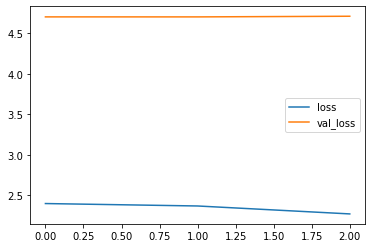

1172/1172 [==============================] - 5s 4ms/step - loss: 2.2677 - val_loss: 4.7118
Epoch 7/1000
 877/1172 [=====================>........] - ETA: 0s - loss: 2.1779

KeyboardInterrupt: 

In [17]:
# Train Model 
%matplotlib inline
plot_losses = PlotLosses()     
epochs = 1000
batch_size = 512
verbose = 1

hist_NN = model.fit(  x=X_train[:,0,:],
                      y=X_train[:,0,:],
                      validation_data=(X_val[:,0,:],
                                       X_val[:,0,:]),
#                       validation_split=0.3,
                      epochs=epochs,
                      batch_size=batch_size,
                      shuffle=False,
                      verbose=verbose,
                      callbacks=[plot_losses])

In [ ]:
# Evaluate
y_train_pred = model.predict(x=[X_train[:,0,:]], verbose=verbose)
y_val_pred = model.predict(x=[X_val[:,0,:]], verbose=verbose)
y_test_pred = model.predict(x=[X_test[:,0,:]], verbose=verbose)

In [ ]:
np.std(y_train_pred)
print('X: ', y_train_pred[0], ' y: ', y_train[0])

In [ ]:
np.shape(X_train_reference)

In [19]:
# Unscaling
if scaling == 1:
    X_train_unscaled = X_normalizer.inverse_transform(X_train[:,0,:])
    X_val_unscaled = X_normalizer.inverse_transform(X_val[:,0,:])
    X_test_unscaled = X_normalizer.inverse_transform(X_test[:,0,:])[:-1]
    
    y_train_pred_unscaled = y_normalizer.inverse_transform(y_train_pred)+ X_train_unscaled[:,3:4]
    y_val_pred_unscaled = y_normalizer.inverse_transform(y_val_pred)+ X_val_unscaled[:,3:4]
    y_test_pred_unscaled = y_normalizer.inverse_transform(y_test_pred)+ X_test_unscaled[:,3:4]

    y_train_unscaled = y_normalizer.inverse_transform(y_train)+ X_train_unscaled[:,3:4]
    y_val_unscaled = y_normalizer.inverse_transform(y_val)+ X_val_unscaled[:,3:4]
    y_test_unscaled = y_normalizer.inverse_transform(y_test)[:-1]+ X_test_unscaled[:,3:4]
    
else:
    y_train_pred_unscaled = y_train_pred
    y_val_pred_unscaled = y_val_pred
    y_test_pred_unscaled = y_test_pred

    y_train_unscaled = y_train 
    y_val_unscaled = y_val 
    y_test_unscaled = y_test[:-1] 
    
mse = np.array([ np.mean((y_train_pred - y_train_unscaled)**2),
                 np.mean((y_val_pred - y_val_unscaled)**2),
                 np.mean((y_test_pred - y_test_unscaled )**2)])


NameError: name 'y_train_pred' is not defined

In [ ]:
# Plot Results
#mpld3.enable_notebook()
# %matplotlib qt
zoom = 100

fig = plt.figure()
fig.set_size_inches(w=15, h=10)

y = np.concatenate((y_train_unscaled, y_val_unscaled, y_test_unscaled))

# First Row
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax1.plot(range(0, len(y)), y)
ax1.plot(range(0, int(split[0])), y_train_pred_unscaled)
ax1.plot(range(int(split[0]), int(split[0] + split[1])), y_val_pred_unscaled)
ax1.plot(range(int(split[0] + split[1]), int(split[0] + split[1] + split[2])-1), y_test_pred_unscaled)

ax1.set_title('Real vs. Prediciton, History: ' + str(history) + ' Delay: ' + str(delay) +'\nMSE_train: ' + str(round(mse[0], 2))\
                  + ' MSE_val: ' + str(round(mse[1]))\
                  + ' MSE_test: ' + str(round(mse[2])));

# Second Row
ind =  np.random.randint(delay, len(y_test))
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax2.plot(X_test_reference[ind+delay:ind+zoom+delay])
ax2.plot(y_test_pred[ind:ind+zoom]+ X_test_reference[ind:ind+zoom])
ax2.set_title('Test Data - Zoom, First ' + str(zoom) + ' Rows')
ax2.legend(['Real', 'Predicition']);

ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)
ax3.plot(y_test[ind:ind+zoom])
ax3.plot(y_test_pred[ind:ind+zoom])
ax3.set_title('Test Data - Zoom, First ' + str(zoom) + ' Rows')
ax3.legend(['Real', 'Predicition']);

fig.tight_layout()
plt.show()